In [1]:
import os
from datetime import datetime  
import tellurium as te
import numpy as np 
import pygmo as pg
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
os.chdir('/mmfs1/gscratch/cheme/dalba/repos/ECFERS')

In [105]:
inputs_df = pd.read_csv('data/inputs.csv')
inputs_df.columns = ['sample','time','dilution_factor','C00058','C00004','C00037','C00149','C00022','C00065','C00036','C00002','C00020','C00010','C00033','C00158HCT','C00011','C00024','p_hEC11719', 'p_hEC11137','p_hEC6411','p_hEC43117']
inputs_df['time'] = inputs_df['time'].apply(lambda x: (x*60+15)*60)

data_df = pd.read_csv('data/data.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()
data_df.columns = ['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','C00047','C00183','C00109','C02630']
data_weights_df = pd.read_csv('data/data_weights_mod.csv').set_index('sample').reindex(inputs_df['sample']).reset_index()

In [83]:
data_weights_df = data_weights_df.set_index('sample')
data_weights_df[~ data_weights_df.isna()] = 1
data_weights_df.reset_index(inplace=True)

In [106]:
def split_df(df, test_on):
    test_vars_df = df[df['sample'].apply(lambda x: any(name in x for name in test_on))]
    train_vars_df = df[~df['sample'].apply(lambda x: any(name in x for name in test_on))]
    return [test_vars_df, train_vars_df]

# test_on = ['pyc_HCT','pyc_HCT_dil','PI', 'es','E_N','TP']
test_on = ['gly','mal','ser','pyr','empty','tdcb','pyc','mdh']
test_vars_df, train_vars_df, test_data_df, train_data_df, test_weights_df, train_weights_df =  sum([split_df(df, test_on) for df in [inputs_df, data_df, data_weights_df]],[])

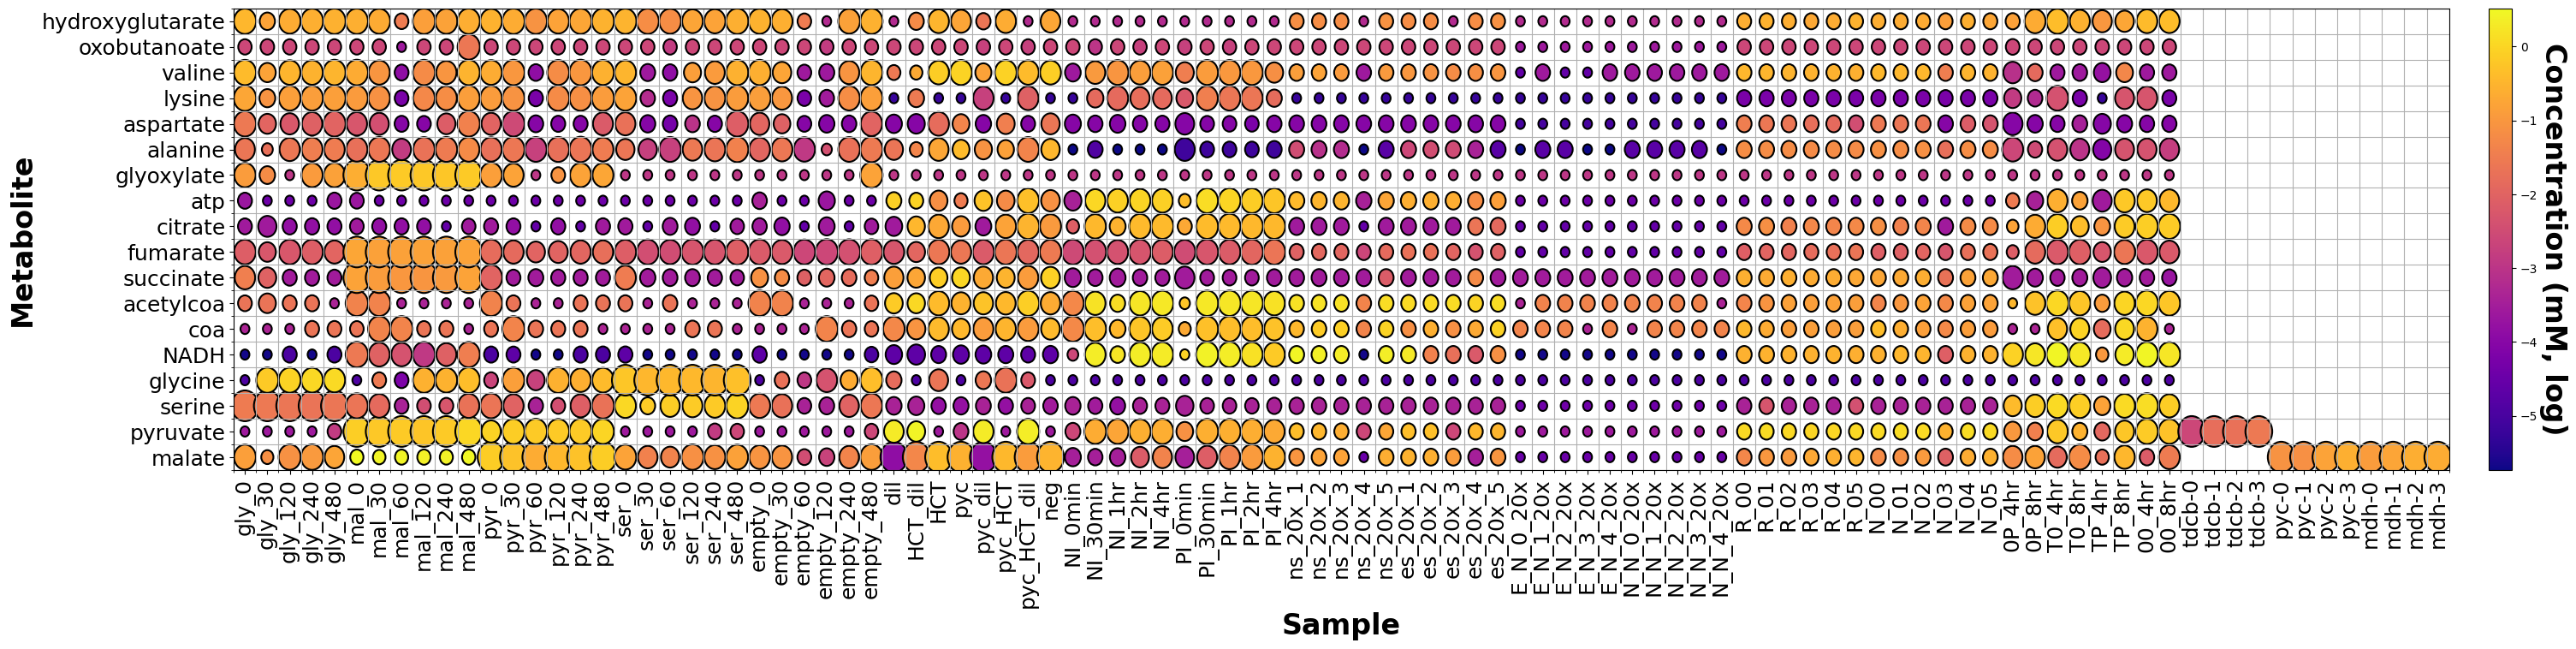

In [107]:
from matplotlib.collections import PatchCollection

def circlemap(data_df, data_weights_df, figsize=(40, 7), ignore = None, log = True, cmap = 'plasma'):
       if ignore:
              data_df = data_df[:-ignore]
              data_weights_df = data_weights_df[:-ignore]
       N, M = data_df.T.shape
       ylabels = data_weights_df.drop(columns=['sample'],inplace=False).columns
       xlabels = data_df['sample']

       x, y = np.meshgrid(np.arange(M), np.arange(N-1))
       s = data_weights_df.drop(columns=['sample'], inplace=False).T.values
       if log:
              c = np.log10(data_df.drop(columns=['sample'], inplace=False).T.values)
       else:
              c = data_df.drop(columns=['sample'], inplace=False).T.values
       fig, ax = plt.subplots(figsize=figsize)

       s[s>1]=1.2
       R = s/2
       circles = [plt.Circle((j,i), radius=r) for r, j, i in zip(R.flat, x.flat, y.flat)]
       col = PatchCollection(circles, array=c.flatten(), cmap=cmap, edgecolors='black', linewidth=1.5)
       ax.add_collection(col)

       ax.set(xticks=np.arange(M), yticks=np.arange(N-1),
              xticklabels=xlabels, yticklabels=ylabels)
       ax.set_xticks(np.arange(M+1)-0.5, minor=True)
       ax.set_yticks(np.arange(N)-0.5, minor=True)
       ax.grid(which='minor')

       plt.xticks(rotation=90)
       plt.tick_params(axis='both', which='major', labelsize=18)

       cbar = fig.colorbar(col, pad = 0.015)
       if log:
              cbar.set_label('Concentration (mM, log)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})
       else:
              cbar.set_label('Concentration (mM)', rotation=270, fontsize=24, labelpad=25, fontdict={'weight': 'bold'})


       plt.xlabel('Sample', fontsize=24, fontdict={'weight': 'bold'})
       plt.ylabel('Metabolite', fontsize=24, fontdict={'weight': 'bold'})

       plt.show()
       
circlemap(data_df, data_weights_df)

In [108]:
test_index_map = pd.merge(test_vars_df, test_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']]
train_index_map = pd.merge(train_vars_df, train_vars_df.drop(columns=['sample','time']).drop_duplicates().reset_index(drop=False))[['sample','time','index']]

In [109]:
train_vars = [train_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]
test_vars = [test_vars_df.drop(columns=['sample','time'], inplace=False).drop_duplicates().T.to_dict()]

train_metadata = [{}]
train_metadata[0]['sample_labels'] = list(train_vars[0].keys())
train_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
train_metadata[0]['timepoints'] = train_index_map.groupby('index')['time'].apply(list).to_dict()

test_metadata = [{}]
test_metadata[0]['sample_labels'] = list(test_vars[0].keys())
test_metadata[0]['measurement_labels'] = list(data_df.columns[1:])
test_metadata[0]['timepoints'] = test_index_map.groupby('index')['time'].apply(list).to_dict()

train_data=[{}]
train_weights=[{}]
for index, samples in train_index_map.groupby('index')['sample'].apply(list).items():
    train_data[0][index]=train_data_df.loc[train_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    train_weights[0][index]=train_weights_df.loc[train_weights_df['sample'].isin(samples)].drop(columns=['sample']).values

test_data=[{}]
test_weights=[{}]
for index, samples in test_index_map.groupby('index')['sample'].apply(list).items():
    test_data[0][index]=test_data_df.loc[test_data_df['sample'].isin(samples)].drop(columns=['sample']).values
    test_weights[0][index]=test_weights_df.loc[test_weights_df['sample'].isin(samples)].drop(columns=['sample']).values


In [110]:
# load SBML model
modelfile = os.getcwd()+'/models/241016_M3.sbml'
r = te.loadSBMLModel(modelfile)

In [113]:
# get all the parameters that can vary during the fitting
kcat_labels = [p for p in r.getGlobalParameterIds() if 'Kcat_V' in p]
keq_labels = [p for p in [p for p in r.getGlobalParameterIds() if 'Keq' in p] if r[p]==1]
km_labels = [p for p in r.getGlobalParameterIds() if 'Km' in p]
ki_labels = [p for p in r.getGlobalParameterIds() if 'Ki' in p]
Gnc_labels = [p for p in r.getGlobalParameterIds() if 'Gnc' in p]
Gc_labels = [p for p in r.getGlobalParameterIds() if 'Gc' in p ]

sbml = r.getSBML()
metabolites = [s for s in r.getFloatingSpeciesIds() if 'EC' not in s]
metabolites_labels = [v for v in [(sbml[sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s):sbml.find('<initialAssignment symbol="'+s+'">')+144+len(s)+5]).split(' ')[0] for s in metabolites]]
heterologous_expression = [p for p in r.getGlobalParameterIds() if 'rel' in p][1:]

parameter_labels = kcat_labels + keq_labels + km_labels + ki_labels + Gnc_labels + Gc_labels + metabolites_labels + heterologous_expression
# parameter_labels = kcat_labels + keq_labels + km_labels + metabolites_labels + heterologous_expression
parameter_labels.append('rel0') # what are good bounds for this?
# parameter_labels.append('rel1') # what are good bounds for this?

# make upper and lower bounds
upper = np.log10(np.array([((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)*10 for i in kcat_labels] + 
                 [10 for i in keq_labels] +
                 [r[i]*10 for i in km_labels] + 
                 [r[i]*10 for i in ki_labels] +
                 [1 for _ in Gnc_labels] +
                 [1 for _ in Gc_labels] +
                 [1000 for _ in metabolites_labels] + 
                 [1000 for _ in heterologous_expression] +
                 [1000]))

lower = np.log10(np.array([((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5)/10 for i in kcat_labels] + 
                 [1/10 for i in keq_labels] +
                 [r[i]/10 for i in km_labels] + 
                 [r[i]/10 for i in ki_labels] +
                 [1/100 for _ in Gnc_labels] +
                 [1/100 for _ in Gc_labels] +
                 [1/1000 for _ in metabolites_labels] + 
                 [1/1000 for _ in heterologous_expression] +
                 [1/1000]))

p_initial = np.log10(np.array([((r['Kcat_F_'+i.split('_')[-1]]*r['Kcat_R_'+i.split('_')[-1]])**0.5) for i in kcat_labels] + 
                     [r[i] for i in keq_labels] +
                     [r[i] for i in km_labels] + 
                     [r[i] for i in ki_labels] +
                     [0.9 for _ in Gnc_labels] +
                     [0.9 for _ in Gc_labels] +
                     [1 for _ in metabolites_labels] + 
                     [1 for _ in heterologous_expression] +
                     [1]))

widths = np.log10(np.array([10 for _ in kcat_labels] +
                  [10 for _ in keq_labels] + 
                  [10 for _ in km_labels] + 
                  [10 for _ in ki_labels] +
                  [1.1 for _ in Gnc_labels] +
                  [1.1 for _ in Gc_labels] +
                  [1000 for _ in metabolites_labels] + 
                  [1000 for _ in heterologous_expression] +
                  [1000]))

# with open('results/240829_M0/parameters.dat', 'wb') as file:
#     pops = pickle.dump([p_initial,upper,lower,widths],file)

In [144]:
p_initial = train_myprob._unscale(pops[0].champion_x)
upper = p_initial+3
upper[['G' in p for p in parameter_labels]] = 0
lower = p_initial-3

In [149]:
from src.fitting.pygmo_problems import SBMLGlobalFit_Multi_Fly
train_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = train_data, 
    data_weights=train_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=train_metadata,
    variables=train_vars,
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=1,
    dlambda = 10,
    llambda=0.05, 
    rmse='mean')

test_myprob = SBMLGlobalFit_Multi_Fly(
    model = [modelfile], 
    data = test_data, 
    data_weights=test_weights,
    parameter_labels=parameter_labels, 
    lower_bounds=lower, upper_bounds=upper, 
    metadata=test_metadata,
    variables=test_vars,
    scale=True,
    log=[True]*len(parameter_labels),
    elambda=1,
    dlambda = 10,
    llambda=0.05, 
    rmse='mean')

with open('results/241004_M3_spiked/241004_train_myprob2.obj', 'wb') as file:
    pickle.dump(train_myprob, file)
with open('results/241004_M3_spiked/241004_test_myprob2.obj', 'wb') as file:
    pickle.dump(test_myprob, file)

train_prob = pg.problem(test_myprob) # SWAPED THEM HERE FOR TESTING
test_prob = pg.problem(train_myprob)

In [17]:
import ipyparallel as ipp
from src.fitting.pygmo_bfes import pickleless_bfe

client = ipp.Client(profile='cheme-ecfers')
client[:].apply_sync(os.chdir,'/mmfs1/gscratch/cheme/dalba/repos/ECFERS');

def set_affinity_on_worker():
    """When a new worker process is created, the affinity is set to all CPUs"""
    import os
    os.system("taskset -p 0xffffffffff %d" % os.getpid())

client[:].apply_sync(set_affinity_on_worker)

udbfe = pickleless_bfe(client_kwargs={'profile':'cheme-ecfers'}, view_kwargs = {}, temp_dv_path = os.getcwd()+'/models/binaries', prob = {'train':train_prob, 'test':test_prob})
udbfe.init_view(client_kwargs={'profile':'cheme-ecfers'},view_kwargs = {})
mybfe = pg.bfe(udbfe)

In [150]:
udbfe._view.push({'prob_train': train_prob, 'prob_test': test_prob }, block = True) 
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test'))
mybfe = pg.bfe(udbfe)

In [172]:
# pick parameters based on this thesis
# https://repository.up.ac.za/handle/2263/66233#:~:text=The%20thesis%20shows%20that%20the,empirical%20tests%20and%20theoretical%20reasoning.
algos = []
pops = []
replicates = 1
for i in range(replicates):
    a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.1, variant=5, neighb_type=2, neighb_param=4, memory=True)
    # a = pg.gaco(gen=10)
    # a = pg.scipy_optimize(method='Nelder-Mead')
    a.set_bfe(mybfe)
    algo = pg.algorithm(a)
    algo.set_verbosity(1)
    algos.append(algo)
    # train_prob.extract(SBMLGlobalFit_Multi_Fly)._setup_rr()
    pops.append(pg.population(train_prob, size = 0))

In [173]:
total_nodes = len(client[:])
for p in pops:
    xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(p-w,p+w, total_nodes)) for p,w in zip(p_initial,widths)])).T
    # xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(l,u, total_nodes)) for l,u in zip(train_myprob.lowerb,train_myprob.upperb)])).T
    fs = udbfe(train_prob,xs.reshape(-1))
    # fs = np.apply_along_axis(train_prob.fitness, 1, xs)
    list(map(p.push_back, xs, fs[:,np.newaxis]))
    # list(map(p.push_back, xs, fs))

with open('results/241004_M3_spiked/checkpoint_ABR.dat', 'wb') as file:
    pickle.dump(pops, file)

In [373]:
with open('results/240829_M3/logs_ABR2.dat', 'rb') as file:
    logs, test_fit = pickle.load(file)

with open('results/240829_M3/checkpoint_ABR2.dat', 'rb') as file:
    pops = pickle.load(file)

with open('results/240829_M3/bounds_ABR.dat', 'rb') as file:
    all_lower,all_upper = pickle.load(file)

In [374]:
train_myprob.set_bounds(all_upper[-1],all_lower[-1])
# train_prob = pg.problem(train_myprob)
test_prob = pg.problem(train_myprob)

test_myprob.set_bounds(all_upper[-1],all_lower[-1])
# test_prob = pg.problem(test_myprob)
train_prob = pg.problem(test_myprob)

udbfe._view.push({'prob_train': train_prob, 'prob_test': test_prob}, block = True)
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test'))
mybfe = pg.bfe(udbfe)

In [174]:
import pickle
now = lambda: datetime.fromtimestamp(datetime.now().timestamp()).strftime("%d-%m-%Y, %H:%M:%S")
logs = [[] for _ in range(replicates)]
test_fit = []
all_upper = [train_myprob.upperb]
all_lower = [train_myprob.lowerb]
n=0
for k in range(100):
    print(now() + ' - Starting evolution ' + str(k))
    pops = [a.evolve(p) for a,p in zip(algos,pops)]

    print(now() + ' - Evolution done. Best fitness: ' + str(np.min([p.champion_f for p in pops])))
    print(now() + ' - Best rel0: ' + str(train_myprob._unscale(pops[0].champion_x)[-1]))

    # test_fit.append([[udbfe(test_prob,p.get_x().reshape(-1), mode = 'test')] for p in pops])
    for i,a in enumerate(algos):
        logs[i].append(np.array(a.extract(pg.pso_gen).get_log()))

    with open('results/241004_M3_spiked/logs_ABR.dat', 'wb') as file:
        pickle.dump([logs,test_fit], file)

    with open('results/241004_M3_spiked/checkpoint_ABR.dat', 'wb') as file:
        pickle.dump(pops, file)
    
    if (k>0) & (k%10 == 0):
        print(now() + ' - Changing bounds, resampling population')

        x_u = np.apply_along_axis(train_myprob._unscale, 1, pops[0].get_x())
        f_u = pops[0].get_f()

        increase_lower = sum(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*10//100],:]<train_myprob._scale(p_initial)/(100*(5**n)))>0 # /30>0.3 # divide by extra 5 each round
        increase_upper = sum(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*10//100],:]>0.95)>0 # /30>0.3
        n += 1
        
        new_upper = increase_upper*train_myprob.upperb+np.log10(10) + (~increase_upper)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].max(0))
        new_lower = increase_lower*train_myprob.lowerb-np.log10(10) + (~increase_lower)*train_myprob._unscale(pops[0].get_x()[np.argsort(f_u[:,0])[:len(pops[0])*75//100],:].min(0))
        new_upper[['G' in p for p in parameter_labels]] = np.log10(1) # clamp G to 1
        new_upper,new_lower = np.max([new_upper, new_lower], axis = 0), np.min([new_upper, new_lower], axis = 0) # make sure lower < upper
        
        keep = np.argsort(pops[0].get_f()[:,0])[:-len(pops[0])//4]
        # for i,x in enumerate(x_u):
        #     if (np.all([x <= new_upper]) & np.all([x >= new_lower])):
        #         keep.append(i)

        train_myprob.set_bounds(new_upper,new_lower)
        train_prob = pg.problem(train_myprob)
        # test_prob = pg.problem(train_myprob)

        test_myprob.set_bounds(new_upper,new_lower)
        test_prob = pg.problem(test_myprob)
        # train_prob = pg.problem(test_myprob)

        udbfe._view.push({'prob_train': train_prob , 'prob_test':test_prob }, block = True) 
        udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_train'))
        udbfe._view.apply_sync(lambda x: x.extract(SBMLGlobalFit_Multi_Fly)._setup_rr(), ipp.Reference('prob_test'))
        mybfe = pg.bfe(udbfe)

        algos = []
        pops = []
        replicates = 1
        for i in range(replicates):
            a = pg.pso_gen(gen=10,omega=0.95, eta1=0.25, eta2=0.25, max_vel=0.1, variant=5, neighb_type=2, neighb_param=4, memory=True)
            a.set_bfe(mybfe)
            algo = pg.algorithm(a)
            algo.set_verbosity(1)
            algos.append(algo)
            pops.append(pg.population(train_prob, size = 0))

        for p in pops:
            xs = np.apply_along_axis(train_myprob._scale, 1, x_u[keep,:]) # new scaling
            list(map(p.push_back, xs, f_u[keep,:]))
            
            xs = np.apply_along_axis(train_myprob._scale, 0, np.array([(np.random.uniform(l,u, len(x_u)-len(keep))) for l,u in zip(new_lower,new_upper)])).T
            fs = udbfe(train_prob,xs.reshape(-1))
            list(map(p.push_back, xs, fs[:,np.newaxis]))
        
        all_upper.append(train_myprob.upperb)
        all_lower.append(train_myprob.lowerb)
        with open('results/241004_M3_spiked/bounds_ABR.dat', 'wb') as file:
            pickle.dump([all_lower,all_upper], file)

19-10-2024, 18:17:25 - Starting evolution 0

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            600      0.0336758      0.0171932       0.049347        12.3616
      2           1200      0.0336758      0.0154309      0.0493463        12.2943
      3           1800      0.0336758      0.0169144      0.0493458         12.197
      4           2400      0.0336758      0.0197647      0.0493451        12.1388
      5           3000      0.0336758      0.0213168      0.0493427        12.1487
      6           3600      0.0336758      0.0200773      0.0493352        12.1967
      7           4200      0.0336758      0.0171861      0.0493327        12.2325
      8           4800      0.0336758      0.0157437      0.0493309        12.2291

   Gen:        Fevals:         gbest:     Mean Vel.:    Mean lbest:    Avg. Dist.:
      1            600       0.125913      0.0454458       0.141041        7.25893
      2           1200       0.124332    

KeyboardInterrupt: 

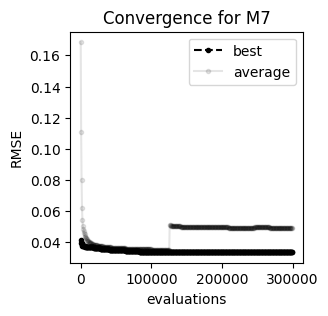

In [154]:
results = [np.concatenate(l,axis=0) for l in logs]
plt.figure(figsize=(3,3))
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,2],'.k--', label = 'best') for res in results]
[plt.plot(np.arange(0,len(res[:,2])*600,600),res[:,4],'.k-', alpha = 0.1, label = 'average') for res in results]
# plt.xscale('log')
# plt.ylim(0.001,0.003)

# test_evals = np.arange(1,len(np.squeeze(np.array(test_fit)))*10*600,10*600)
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).mean(axis=1),'or-', alpha = 0.4, label = 'average, test')
# plt.plot(test_evals, np.squeeze(np.array(test_fit)).min(axis=1),'or-', label = 'best, test')

# plt.yscale('log')
plt.ylabel('RMSE')
plt.xlabel('evaluations')
plt.title('Convergence for M7')  
plt.legend()
# plt.text(1800000, 19, 'n = 1 \np = 600');

In [122]:
test_myprob._setup_rr()
train_myprob._setup_rr()
all_train = []
all_test = []
all_results = [[{s:[] for s in m['sample_labels']} for m in t.metadata] for t in [train_myprob, test_myprob]] 
for k,c in enumerate([p_initial, train_myprob._unscale(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:1],:])[0]]):
    test_res = test_myprob._simulate(10**(c))
    train_res = train_myprob._simulate(10**c)
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[0], train_res, train_myprob.metadata, train_myprob.model_stuff)]
    [[a[s].append(res_dict[s][:,ms.cols[s]][ms.rows[s],:]) for s in m['sample_labels']] for a, res_dict, m, ms in zip(all_results[1], test_res, test_myprob.metadata, test_myprob.model_stuff)]
    all_train.append(train_res)
    all_test.append(test_res)

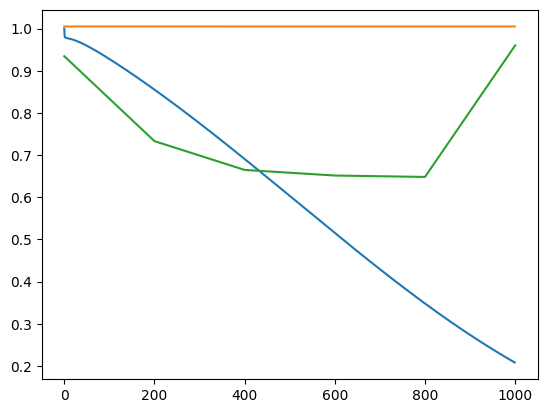

In [123]:
plt.plot(all_test[0][0][11][:,98])
plt.plot(all_test[1][0][11][:,98])
plt.plot(np.linspace(0,1000,6),test_myprob.data[0][11][:,1])

In [124]:
compiled_results = {}
ms = train_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(train_index_map['index'],train_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = all_train[1][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
train_results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
train_results_df.columns = np.array(['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','...','C00183','C00109','C02630'])[[0,*np.array(ms.data_cols[i])+1]]

In [125]:
compiled_results = {}
ms = test_myprob.model_stuff[0]
k = 0
prev_i = None
for i, s in zip(test_index_map['index'],test_index_map['sample']):
    if prev_i is not None:
        if i != prev_i:
            k = 0
    compiled_results[s] = all_test[1][0][i][:,ms.cols[i]][ms.rows[i],:][k,:]
    k = k+1
    prev_i = i
test_results_df = pd.DataFrame.from_dict(compiled_results).T.reset_index()
test_results_df.columns = np.array(['sample','C00149','C00022','C00065','C00037','C00004','C00010','C00024','C00042','C00122','C00158','C00002','C00048','C00041','C00049','...','C00183','C00109','C02630'])[[0,*np.array(ms.data_cols[i])+1]]

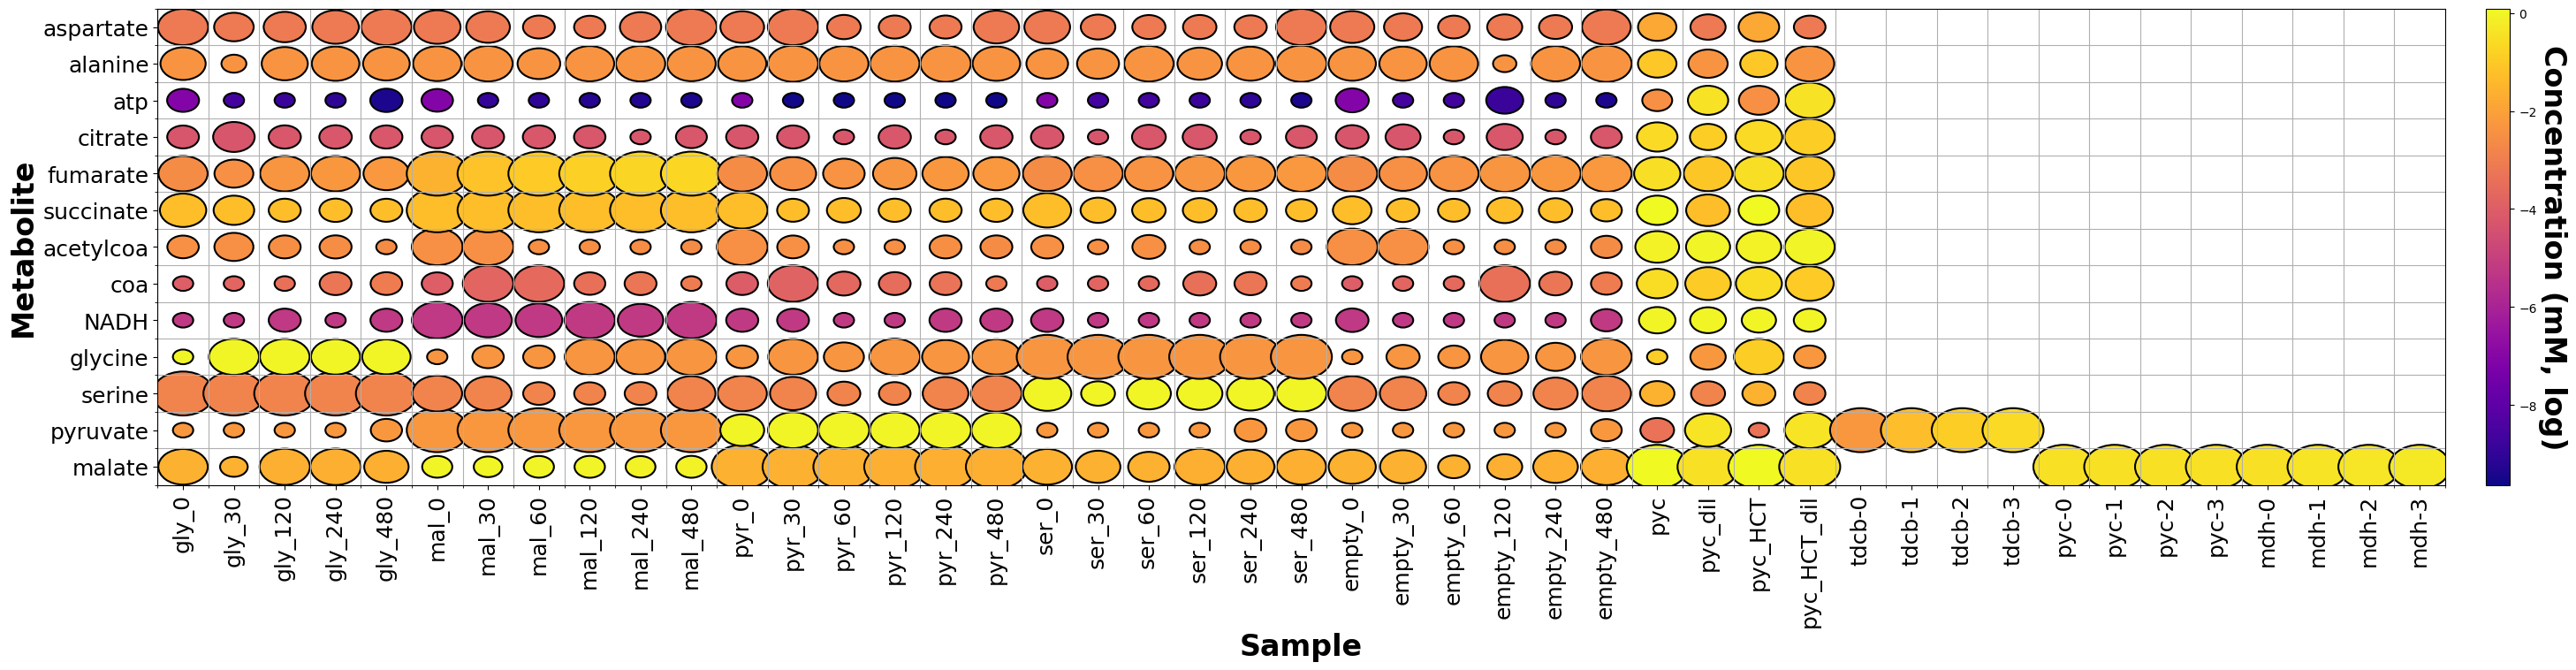

In [126]:
circlemap(test_results_df, test_weights_df.iloc[:,[0,*np.array(ms.data_cols[i])+1]])

In [42]:
test_results_df

sample     C00149    C00022    C00065    C00037    C00004    C00010  \
0         gly_0   0.001576  0.000211  0.000520  1.000009  0.016099  0.000003   
1        gly_30   0.001273  0.000656  0.000520  1.000009  0.016045  0.000006   
2       gly_120   0.000802  0.002621  0.000520  1.000009  0.015727  0.000013   
3       gly_240   0.000264  0.006447  0.000520  1.000008  0.014580  0.000026   
4       gly_480   0.000124  0.014654  0.000520  1.000007  0.011411  0.000041   
5         mal_0   0.823371  0.000468  0.000520  0.000009  0.016195  0.000004   
6        mal_30   0.708560  0.001323  0.000520  0.000009  0.016194  0.000007   
7        mal_60   0.685575  0.002603  0.000520  0.000009  0.016192  0.000012   
8       mal_120   0.678612  0.007802  0.000520  0.000009  0.016183  0.000032   
9       mal_240   0.649543  0.090673  0.000520  0.000009  0.015920  0.000859   
10      mal_480   0.565073  0.465521  0.000520  0.000009  0.014606  0.001779   
11        pyr_0   0.001742  0.999749  0.000520  0.000009  0.015842  0.000002   
12       pyr_30   0.001590  0.999360  0.000520  0.000009  0.015524  0.000003   
13       pyr_60   0.001646  0.998893  0.000520  0.000009  0.015238  0.000004   
14      pyr_120   0.001910  0.997655  0.000520  0.000009  0.014716  0.000005   
15      pyr_240   0.002696  0.994151  0.000520  0.000009  0.013871  0.000005   
16      pyr_480   0.004346  0.985197  0.000520  0.000009  0.012950  0.000006   
17        ser_0   0.001572  0.000224  1.000520  0.000009  0.016093  0.000003   
18       ser_30   0.001258  0.000704  1.000520  0.000009  0.016030  0.000006   
19       ser_60   0.001095  0.001286  1.000520  0.000009  0.015946  0.000008   
20      ser_120   0.000747  0.002828  1.000520  0.000009  0.015668  0.000014   
21      ser_240   0.000237  0.006725  1.000520  0.000009  0.014445  0.000027   
22      ser_480   0.000120  0.014938  1.000520  0.000009  0.011277  0.000042   
23      empty_0   0.001572  0.000224  0.000520  0.000009  0.016093  0.000003   
24     empty_30   0.001258  0.000704  0.000520  0.000009  0.016030  0.000006   
25     empty_60   0.001095  0.001286  0.000520  0.000009  0.015946  0.000008   
26    empty_120   0.000747  0.002828  0.000520  0.000009  0.015668  0.000014   
27    empty_240   0.000237  0.006725  0.000520  0.000009  0.014445  0.000027   
28    empty_480   0.000120  0.014938  0.000520  0.000009  0.011277  0.000042   
29          pyc  10.353634  0.563051  0.010408  0.000200  0.745093  0.715488   
30      pyc_dil   1.882855  0.126770  0.000520  0.000009  0.683837  0.914055   
31      pyc_HCT  10.352353  0.563137  0.010408  0.000200  0.745127  0.715336   
32  pyc_HCT_dil   1.878997  0.126982  0.000520  0.000009  0.683380  0.913765   
33       tdcb-0   0.000216  0.022390  1.000520  0.000009  0.009294  0.000086   
34       tdcb-1   0.006938  0.711803  0.048524  0.000016  0.013491  0.000016   
35       tdcb-2   0.006945  0.688541  0.045905  0.000016  0.013512  0.000017   
36       tdcb-3   0.006957  0.688172  0.045859  0.000016  0.013515  0.000017   
37        pyc-0   1.910079  0.145570  0.000520  0.000009  0.663141  0.900463   
38        pyc-1   1.910093  0.145561  0.000520  0.000009  0.663142  0.900476   
39        pyc-2   1.910120  0.145545  0.000520  0.000009  0.663143  0.900501   
40        pyc-3   1.910160  0.145521  0.000520  0.000009  0.663145  0.900539   
41        mdh-0   0.300760  0.305814  0.000520  0.000009  0.670437  0.002131   
42        mdh-1   1.361290  0.047733  0.000520  0.000009  0.971564  0.009205   
43        mdh-2   1.391069  0.011162  0.000520  0.000009  1.004290  0.009404   
44        mdh-3   1.392409  0.010990  0.000520  0.000009  1.004479  0.009405   

      C00024    C00042    C00122    C00158    C00002    C00041        C00049  
0   0.001541  0.244306  0.000429  0.384654  0.000059  0.000003  5.084201e-07  
1   0.001597  0.244307  0.000589  0.384596  0.000067  0.000003  5.084201e-07  
2   0.001848  0.244314  0.000432  0.384242  0.000096  0.000003  5.084201e-07  
3   0.002299

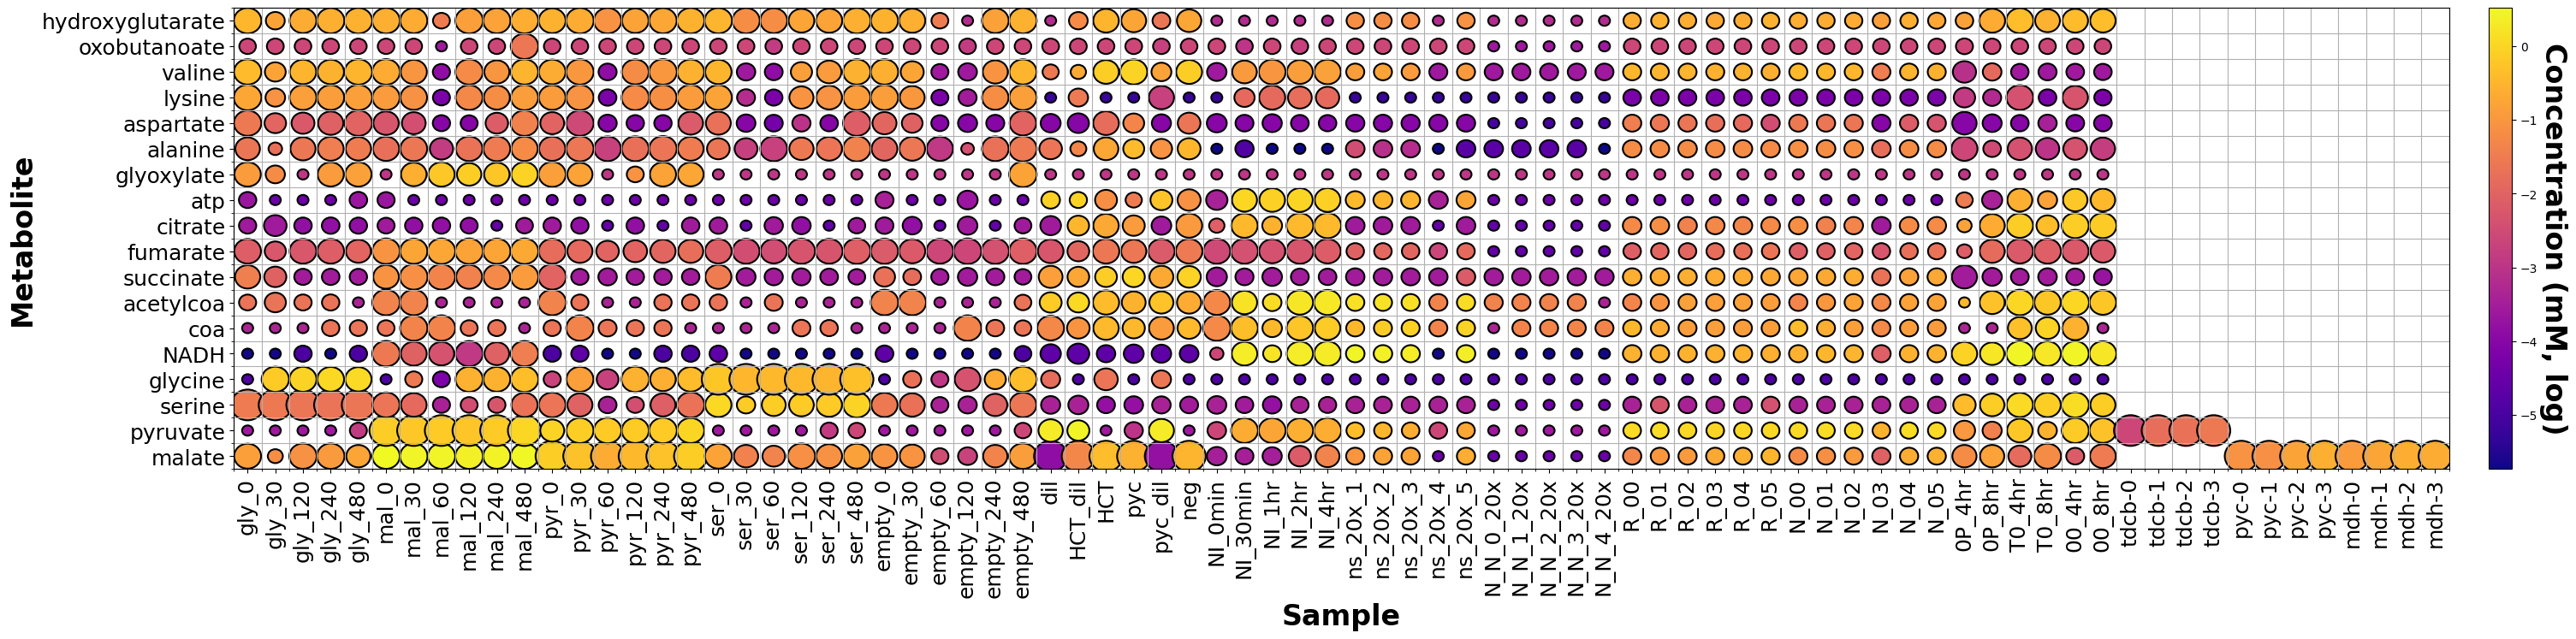

In [88]:
circlemap(train_data_df, train_weights_df)

In [138]:
order = ['neg','pyc','HCT','pyc_HCT','dil','pyc_dil', 'HCT_dil','pyc_HCT_dil']
train = ['neg','pyc','HCT','dil','pyc_dil', 'HCT_dil']
test  = ['pyc_HCT','pyc_HCT_dil'] 

KeyError: "['pyc', 'pyc_dil'] not in index"

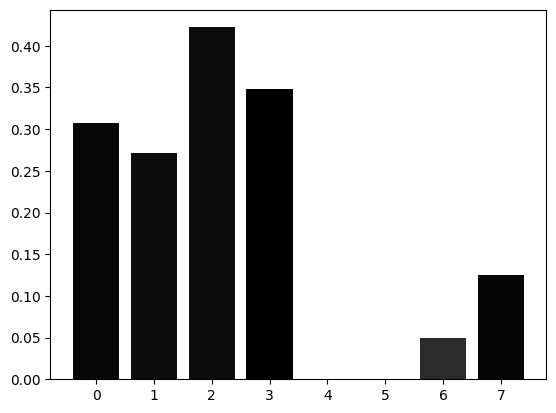

In [139]:
ax = plt.bar(range(8), data_df.set_index('sample').loc[order]['C00149'],color='k', label='data')
for bar, alpha in zip(ax.patches, data_weights_df.set_index('sample').loc[order]['malate'].values):
    bar.set_alpha(alpha/2)

plt.plot([0,1,2,4,5,6],train_results_df.set_index('sample').loc[train]['C00149'], 'o', label='model - train')
plt.plot([3,7],test_results_df.set_index('sample').loc[test]['C00149'], 'o', label='model - test')

plt.plot([0,1,2,4,5,6],train_results_df0.set_index('sample').loc[train]['C00149'], 'ro', label='model - no fit')
plt.plot([3,7],test_results_df0.set_index('sample').loc[test]['C00149'], 'ro')

plt.xticks(range(8),order,rotation=45)
plt.legend()
plt.ylabel('[Malate] (mM)')

Text(0, 0.5, '[Malate] (mM)')

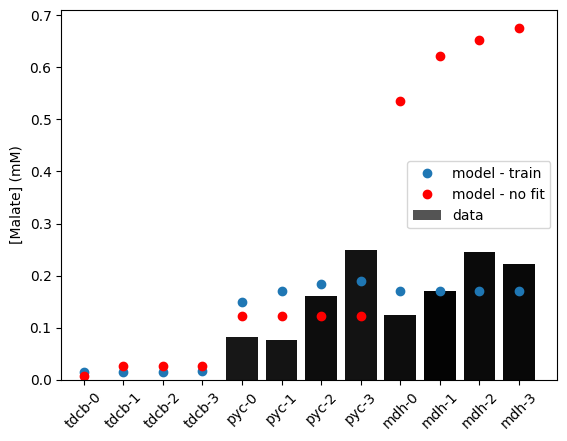

In [ ]:
order = ['tdcb-0','tdcb-1','tdcb-2','tdcb-3','pyc-0','pyc-1','pyc-2','pyc-3','mdh-0','mdh-1','mdh-2','mdh-3']

ax = plt.bar(range(12), data_df.set_index('sample').loc[order]['C00149'],color='k', label='data')
for bar, alpha in zip(ax.patches, [*data_weights_df.set_index('sample').loc[order[:4]]['pyruvate'].values, *data_weights_df.set_index('sample').loc[order[4:]]['malate'].values]):
    bar.set_alpha(alpha/2)

plt.plot(range(12),train_results_df.set_index('sample').loc[order]['C00149'], 'o', label='model - train')

plt.plot(range(12),train_results_df0.set_index('sample').loc[order]['C00149'], 'ro', label='model - no fit')

plt.xticks(range(12),order,rotation=45)
plt.legend()
plt.ylabel('[Malate] (mM)')

plt.figure()
ax = plt.bar(range(12), data_df.set_index('sample').loc[order]['C00022'],color='k', label='data')
for bar, alpha in zip(ax.patches, [*data_weights_df.set_index('sample').loc[order[:4]]['pyruvate'].values, *data_weights_df.set_index('sample').loc[order[4:]]['malate'].values]):
    bar.set_alpha(alpha/2)

plt.plot(range(12),train_results_df.set_index('sample').loc[order]['C00022'], 'o', label='model - train')

plt.plot(range(12),train_results_df0.set_index('sample').loc[order]['C00022'], 'ro', label='model - no fit')

plt.xticks(range(12),order,rotation=45)
plt.legend()
plt.ylabel('[Pyruvate] (mM)')

In [47]:
test_data_df

sample    C00149    C00022    C00065    C00037    C00004    C00010  \
0         gly_0  0.135676  0.000247  0.030789  0.000012  0.000002  0.000440   
1        gly_30  0.071158  0.000247  0.026854  0.654773  0.000002  0.000440   
2       gly_120  0.080357  0.000247  0.023592  0.904339  0.000012  0.000440   
3       gly_240  0.111273  0.000247  0.021496  1.112191  0.000002  0.023007   
4       gly_480  0.175603  0.001358  0.023754  1.191335  0.000012  0.022261   
5         mal_0  3.282441  0.787197  0.022909  0.000012  0.027037  0.023207   
6        mal_30  2.729421  0.631493  0.013969  0.029014  0.009355  0.044776   
7        mal_60  2.765411  0.652608  0.000394  0.000066  0.004554  0.045203   
8       mal_120  2.477808  0.559599  0.003639  0.267610  0.001255  0.022954   
9       mal_240  2.526880  0.643242  0.005151  0.287543  0.008691  0.022317   
10      mal_480  3.068188  1.035873  0.020292  0.445286  0.033904  0.000440   
11        pyr_0  0.720468  0.934453  0.023056  0.002097  0.000012  0.022356   
12       pyr_30  0.496612  0.733046  0.009821  0.133445  0.000021  0.044744   
13       pyr_60  0.230628  0.664714  0.000394  0.001935  0.000002  0.022553   
14      pyr_120  0.347606  0.651476  0.003654  0.269657  0.000002  0.022453   
15      pyr_240  0.500370  0.648117  0.008472  0.256008  0.000012  0.022245   
16      pyr_480  0.741453  0.960009  0.020492  0.394450  0.000012  0.000440   
17        ser_0  0.161676  0.000247  1.112999  0.597862  0.000021  0.000440   
18       ser_30  0.040952  0.000247  0.701079  0.340140  0.000002  0.000440   
19       ser_60  0.042059  0.000247  0.744236  0.356400  0.000002  0.000440   
20      ser_120  0.075166  0.000247  0.695577  0.348879  0.000002  0.022523   
21      ser_240  0.078936  0.001358  0.670353  0.310756  0.000002  0.022772   
22      ser_480  0.147815  0.002468  0.913252  0.477144  0.000002  0.000440   
23      empty_0  0.089800  0.000247  0.026314  0.000012  0.000021  0.000440   
24     empty_30  0.086592  0.000247  0.018695  0.019517  0.000002  0.000440   
25     empty_60  0.003407  0.000247  0.000394  0.001127  0.000002  0.000440   
26    empty_120  0.002004  0.000247  0.000394  0.004573  0.000002  0.044389   
27    empty_240  0.045307  0.000247  0.009850  0.209145  0.000002  0.022224   
28    empty_480  0.130887  0.002468  0.025097  0.447623  0.000012  0.022303   
32          pyc  0.271278  0.000987  0.000158  0.000012  0.000021  0.357488   
33      pyc_dil  0.000157  2.033309  0.000394  0.025075  0.000021  0.120156   
34      pyc_HCT  0.348258  0.000247  0.000158  0.020240  0.000021  0.318423   
35  pyc_HCT_dil  0.124494  2.166958  0.000394  0.005874  0.000021  0.114776   
87       tdcb-0       NaN  0.002468       NaN       NaN       NaN       NaN   
88       tdcb-1       NaN  0.016063       NaN       NaN       NaN       NaN   
89       tdcb-2       NaN  0.018735       NaN       NaN       NaN       NaN   
90       tdcb-3       NaN  0.026188       NaN       NaN       NaN       NaN   
91        pyc-0  0.082712       NaN       NaN       NaN       NaN       NaN   
92        pyc-1  0.075462       NaN       NaN       NaN       NaN       NaN   
93        pyc-2  0.161333       NaN       NaN       NaN       NaN       NaN   
94        pyc-3  0.249815       NaN       NaN       NaN       NaN       NaN   
95        mdh-0  0.123514       NaN       NaN       NaN       NaN       NaN   
96        mdh-1  0.169589       NaN       NaN       NaN       NaN       NaN   
97        mdh-2  0.244504       NaN       NaN       NaN       NaN       NaN   
98        mdh-3  0.221683       NaN       NaN       NaN       NaN       NaN   

      C00024    C00042    C00122    C00158    C00002    C00048    C00041  \
0   0.021453  0.034897  0.007628  0.000271  0.000208  0.121467  0.023783   
1   0.021289  0.009488  0.005544  0.000271  0.000038  0.063483  0.017818   
2   0.021280  0.000275  0.005459  0.000149  0.000038  0.001069  0.025847   
3   0.021230  0.000275  0.007826  0.000149  0.000038  0.118383  0.0334

<Axes: xlabel='sample'>

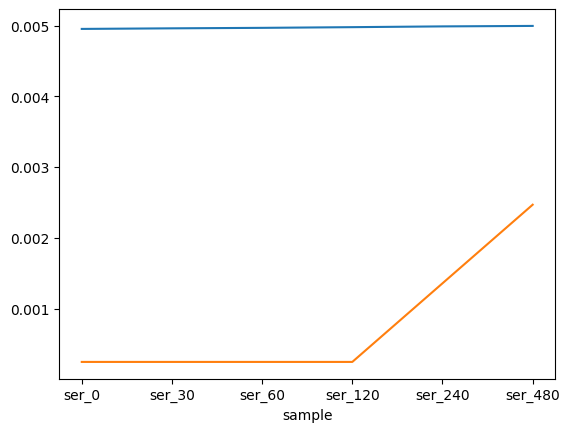

In [127]:
# results_df0.set_index('sample').loc[test_index_map[test_index_map['index'] == 6]['sample']]['C00149'].plot()
test_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00022'].plot()
test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 17]['sample']]['C00022'].plot()

In [128]:
plt.plot(train_res[0][11][0,:],'.')
plt.plot(train_res[0][11][-1,:],'.r', alpha =0.5)
plt.yscale('log')

KeyError: 11

In [234]:
np.where([p=='C00022' for p in test_myprob.r[0].getFloatingSpeciesIds()])

(array([98]),)

In [ ]:
plt.plot(np.linspace(0,480,1000),test_res[0][12][:,98])
plt.plot([0,30,60,120,240,480],results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 12]['sample']]['C00149'])

KeyError: 12

<Axes: xlabel='sample'>

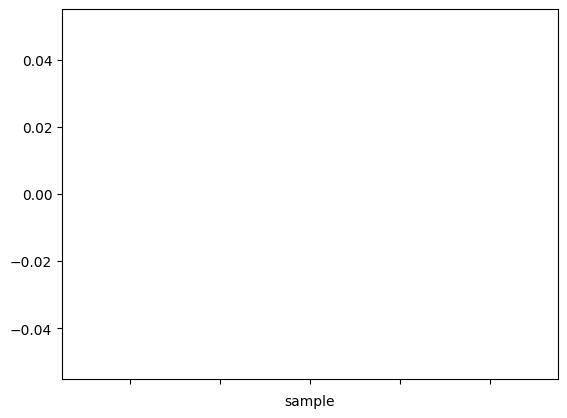

In [ ]:
results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].plot()
test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 5]['sample']]['C00022'].plot()

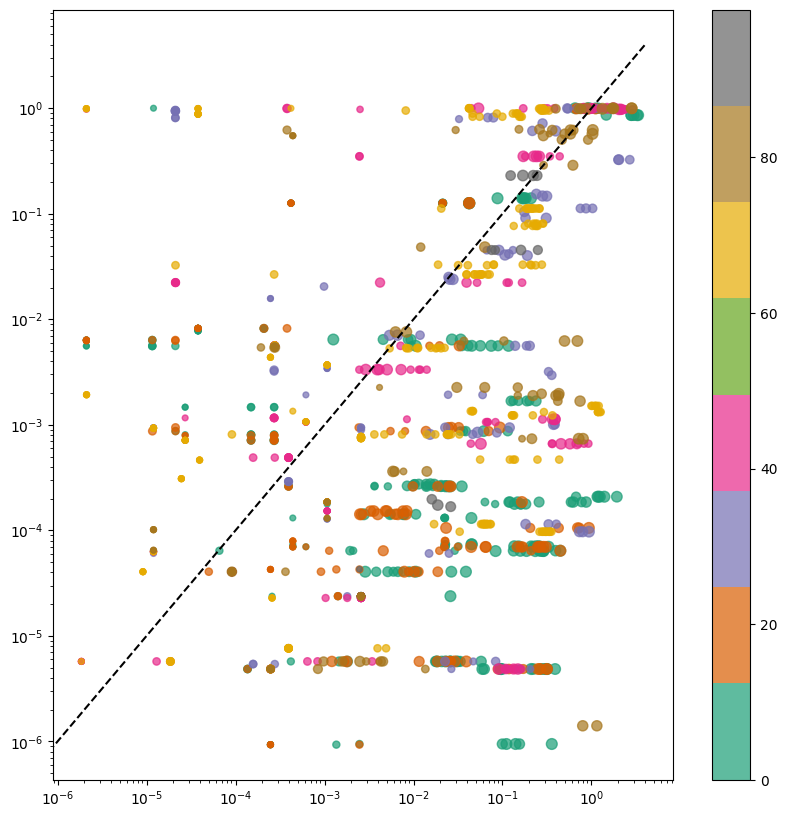

In [196]:
plt.figure(figsize=(10,10))
plt.scatter(train_data_df.drop(columns=['sample','C00047'], inplace=False).values.flatten(), 
            results_df.drop(columns=['sample'], inplace=False).values.flatten(), 
            s = np.exp(np.exp(train_weights_df.drop(columns=['sample','lysine'], inplace=False).values.flatten()))*4, 
            alpha=0.7, 
            c = (train_index_map['index'].values[np.newaxis].T*np.ones((len(train_data_df),len(train_data_df.columns)-2))).flatten(), cmap = 'Dark2')

plt.plot([0,4],[0,4],'k--')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

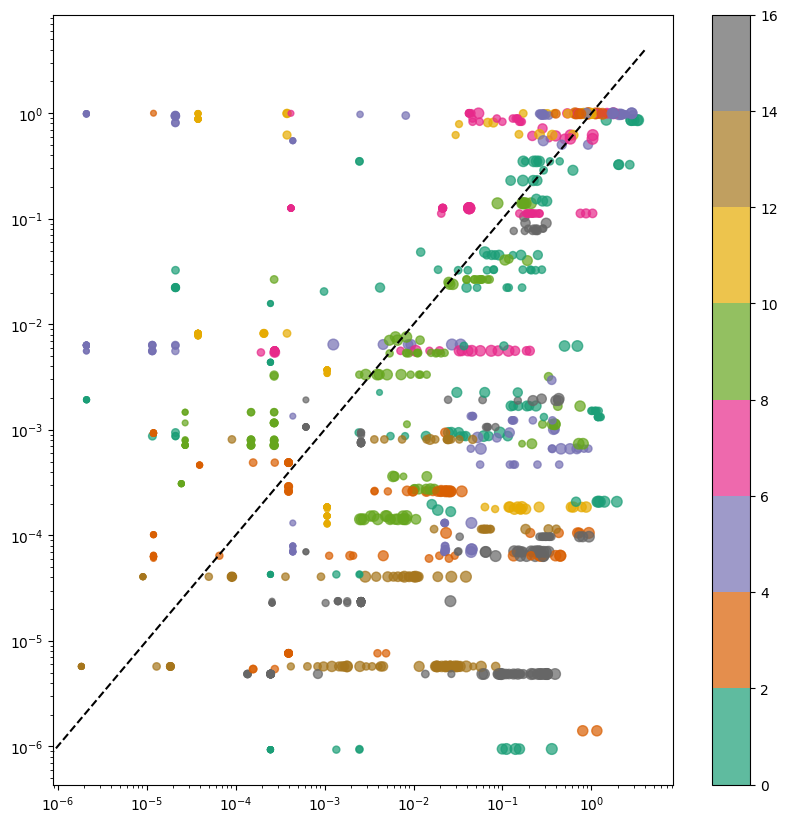

In [198]:
plt.figure(figsize=(10,10))
plt.scatter(train_data_df.drop(columns=['sample','C00047'], inplace=False).values.flatten(), 
            results_df.drop(columns=['sample'], inplace=False).values.flatten(), 
            s = np.exp(np.exp(train_weights_df.drop(columns=['sample','lysine'], inplace=False).values.flatten()))*4, 
            alpha=0.7, 
            c = (np.arange(len(train_data_df.columns)-2)[np.newaxis]*np.ones((len(train_data_df),len(train_data_df.columns)-2))).flatten(), cmap = 'Dark2')

plt.plot([0,4],[0,4],'k--')
plt.yscale('log')
plt.xscale('log')
plt.colorbar()

In [96]:
train_weights_df

sample    malate  pyruvate    serine   glycine      NADH       coa  \
0     gly_0  0.972679  0.400143  1.988328  0.400143  0.400143  0.400143   
1    gly_30  0.544048  0.400143  1.734352  0.986275  0.400143  0.400143   
2   gly_120  0.989460  0.400143  1.998185  0.977100  0.631710  0.400143   
3   gly_240  0.994483  0.400143  1.796531  0.966502  0.400143  0.627540   
4   gly_480  0.873706  0.614965  1.979867  0.951942  0.628721  0.621279   
..      ...       ...       ...       ...       ...       ...       ...   
94    pyc-3  1.850000       NaN       NaN       NaN       NaN       NaN   
95    mdh-0  1.900000       NaN       NaN       NaN       NaN       NaN   
96    mdh-1  1.980000       NaN       NaN       NaN       NaN       NaN   
97    mdh-2  1.920000       NaN       NaN       NaN       NaN       NaN   
98    mdh-3  1.940000       NaN       NaN       NaN       NaN       NaN   

    acetylcoa  succinate  fumarate   citrate       atp  glyoxylate   alanine  \
0    0.618811   0.911922  0.966169  0.624655  0.628927    0.953387  0.889074   
1    0.766967   0.797936  0.764748  0.817669  0.400143    0.694815  0.490706   
2    0.625920   0.630805  0.968739  0.633917  0.400143    0.400143  0.907488   
3    0.630360   0.636065  0.967222  0.639701  0.400143    0.945317  0.935581   
4    0.400143   0.627899  0.901872  0.630723  0.636025    0.954175  0.917816   
..        ...        ...       ...       ...       ...         ...       ...   
94        NaN        NaN       NaN       NaN       NaN         NaN       NaN   
95        NaN        NaN       NaN       NaN       NaN         NaN       NaN   
96        NaN        NaN       NaN       NaN       NaN         NaN       NaN   
97        NaN        NaN       NaN       NaN       NaN         NaN       NaN   
98        NaN        NaN       NaN       NaN       NaN         NaN       NaN   

    aspartate    lysine    valine  oxobutanoate  hydroxyglutarate  
0    0.989318  0.997185  0.987771      0.600698          0.994554  
1    0.778553  0.709509  0.752526      0.609830          0.682265  
2    0.828910  0.972780  0.957205      0.601136          0.969490  
3    0.913932  0.972968  0.958102      0.601410          0.990380  
4    0.994364  0.997063  0.995913      0.600985          0.999235  
..        ...       ...       ...           ...               ...  
94        NaN       NaN       NaN           NaN               NaN  
95        NaN       NaN       NaN           NaN               NaN  
96        NaN       NaN       NaN           NaN               NaN  
97        NaN       NaN       NaN           NaN               NaN  
98        NaN       NaN       NaN           NaN               NaN  

[80 rows x 19 columns]

In [97]:
abs_error = np.abs(train_data_df[train_results_df.columns].drop(columns=['sample'], inplace=False).values-train_results_df.drop(columns=['sample'], inplace=False).values)#*train_weights_df.drop(columns=['sample','lysine'], inplace=False).values
met_err = np.nanmean(abs_error,axis=0)
exp_err = np.nanmean(abs_error,axis=1)

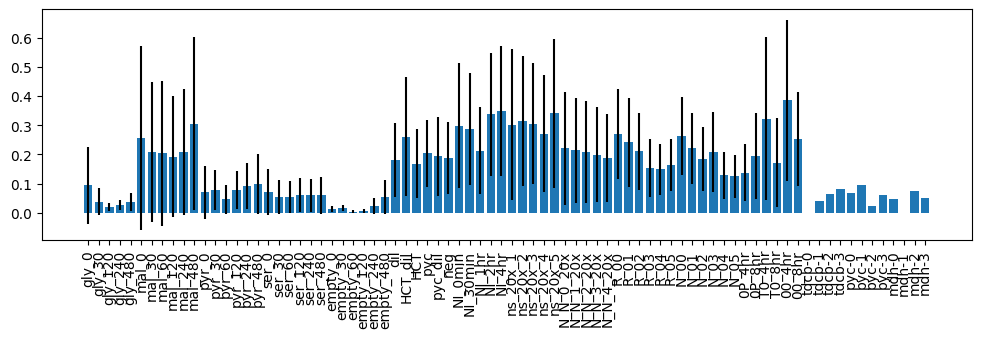

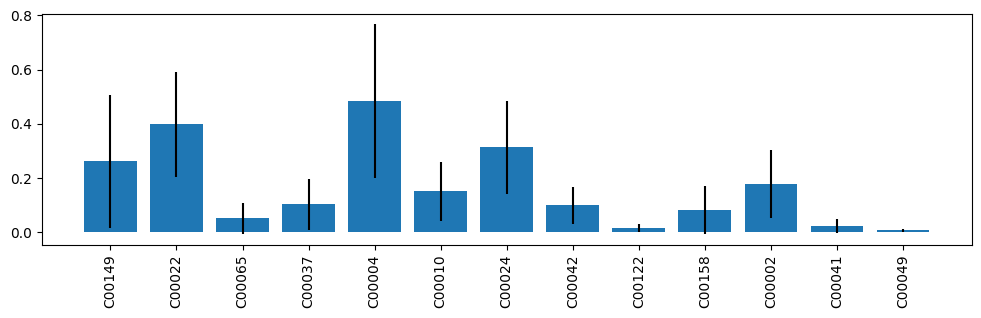

In [99]:
plt.figure(figsize=(12,3))
plt.bar(range(len(exp_err)),exp_err, yerr=np.nanstd(abs_error,axis=1)/2)
plt.xticks(range(len(exp_err)),train_data_df['sample'], rotation=90)

plt.figure(figsize=(12,3))
plt.bar(range(len(met_err)),met_err, yerr=np.nanstd(abs_error,axis=0)/2)
plt.xticks(range(len(met_err)),train_data_df[train_results_df.columns].drop(columns=['sample'], inplace=False).columns, rotation=90);


/tmp/ipykernel_176/4089472006.py:15: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.

/tmp/ipykernel_176/4089472006.py:35: UserWarning:

tight_layout not applied: number of columns in subplot specifications must be multiples of one another.



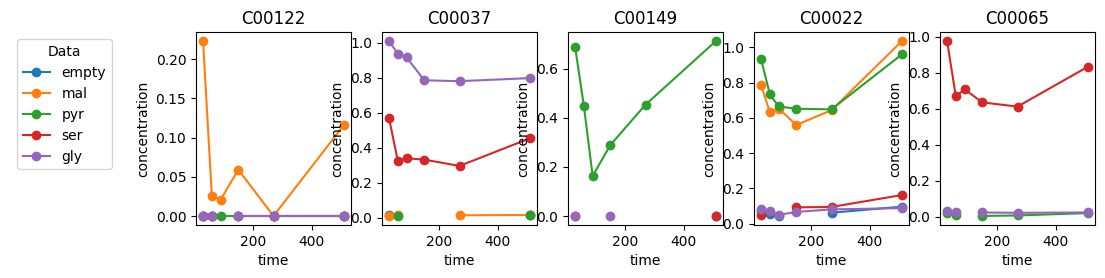

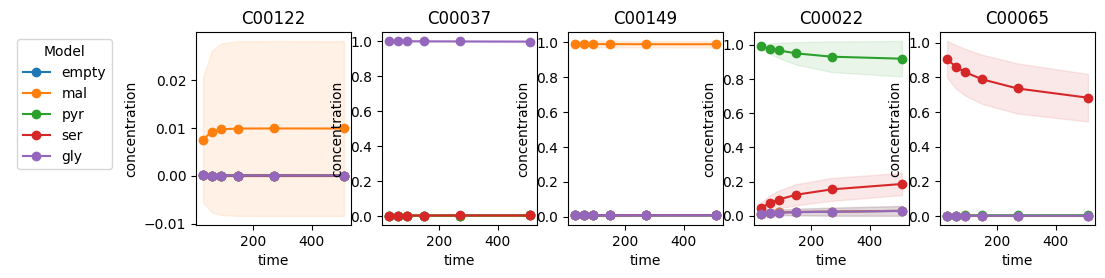

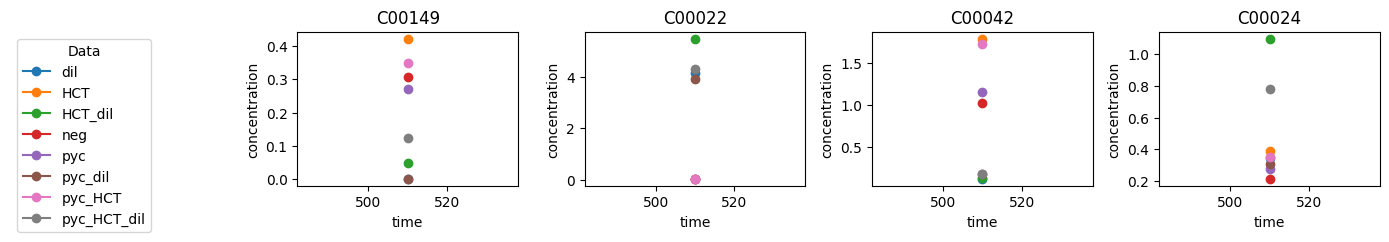

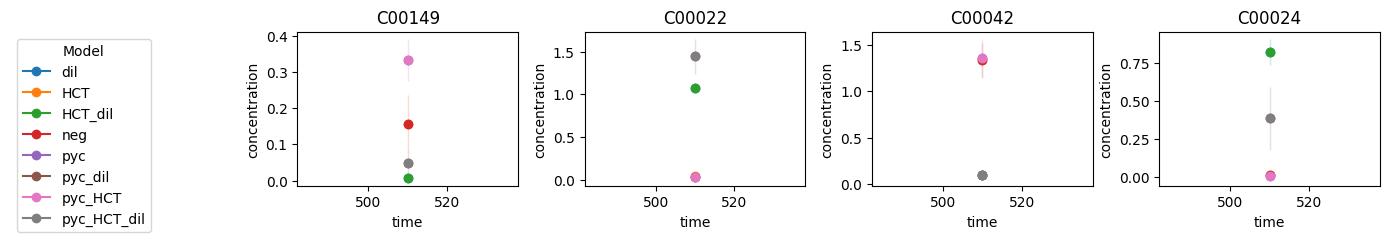

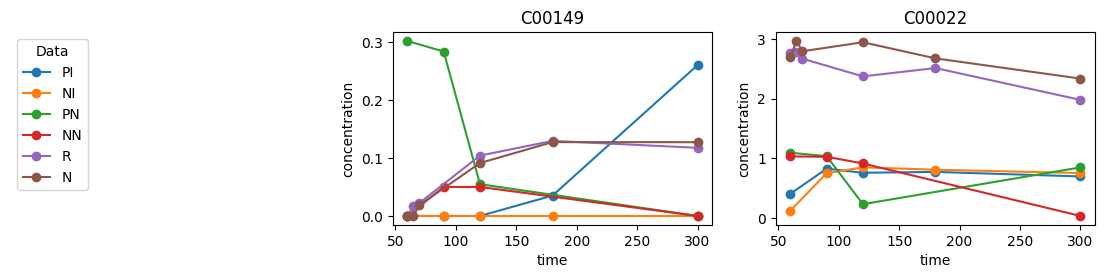

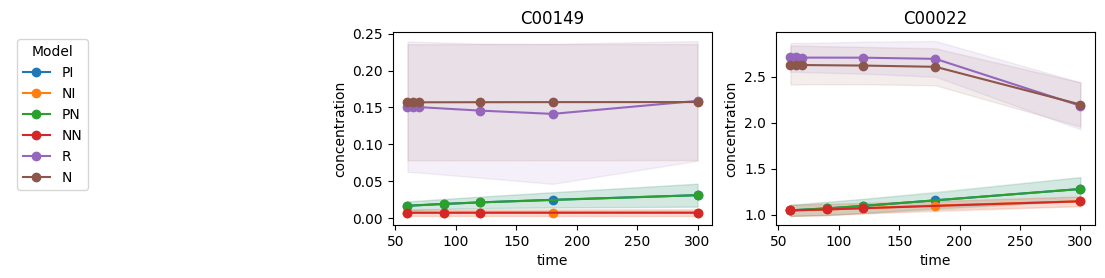

In [31]:
for metadata, measurements, results in zip(train_myprob.metadata, train_myprob.data, all_results[0]):    
    plt.figure(figsize=(14,2.5))
    for s in metadata['sample_labels']:
        for i,m in enumerate(metadata['measurement_labels']):
            plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
            plt.plot(metadata['timepoints'][s]/60, measurements[s][:,i],'-o')
            plt.title(m)
            plt.xlabel('time')
            plt.ylabel('concentration')

    plt.subplot(1,5,1)
    [plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
    plt.legend(metadata['sample_labels'], loc='upper left', title='Data')
    plt.gca().axis('off')
    plt.tight_layout()

    
    plt.figure(figsize=(14,2.5))
    for s in metadata['sample_labels']:
        for i,m in enumerate(metadata['measurement_labels']):
            plt.subplot(1,len(metadata['measurement_labels'])+1,i+2)
            if s in results.keys():
                mean = np.mean(results[s],0)[:,i]
                std = np.std(results[s],0)[:,i]
                p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
                plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
            plt.title(m)
            plt.xlabel('time')
            plt.ylabel('concentration')

    plt.subplot(1,5,1)
    [plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels'] if s in results.keys()]
    plt.legend(results.keys(), loc='upper left', title='Model')
    plt.gca().axis('off')
    plt.tight_layout()
        

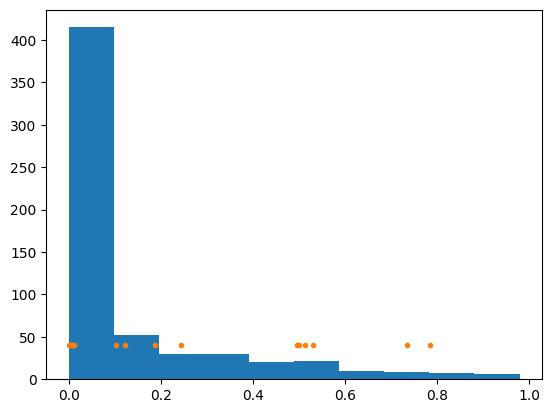

In [20]:
p = 1000
N = 15
plt.hist(pops[0].get_x()[:,p])
# plt.hist(xs[:,p], alpha = 0.5)
plt.plot(pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:N],:][:,p], [40]*N,'.')

In [16]:
uc[600]

0.05179176833832805

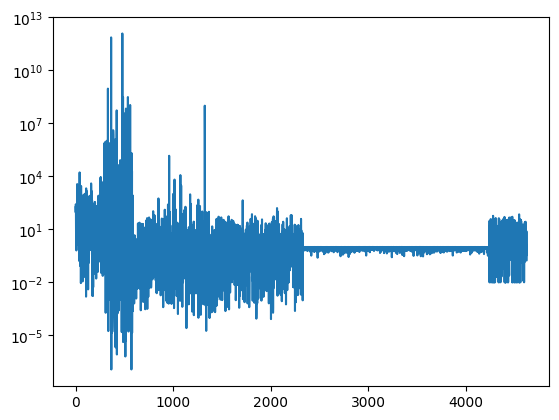

In [116]:
plt.plot(uc)
plt.yscale('log')

(array([  2.,   3.,   7.,  13.,  35.,  82.,  98., 132., 138.,  90.]),
 array([2.35297178, 2.3594543 , 2.36593683, 2.37241935, 2.37890188,
        2.3853844 , 2.39186693, 2.39834945, 2.40483198, 2.4113145 ,
        2.41779703]),
 <BarContainer object of 10 artists>)

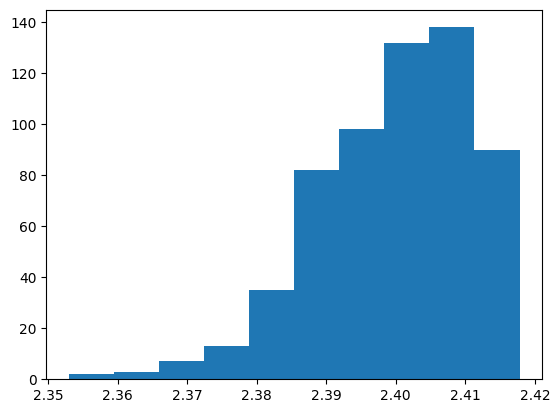

In [18]:
plt.hist((fs))

In [21]:
plt.plot(train_res[0]['ser'][0,:],'.')
plt.plot(train_res[0]['ser'][-1,:],'.r', alpha =0.5)

plt.yscale('log')

NameError: name 'train_res' is not defined

In [9]:
top_pop = pg.population(pg.problem(myprob), size = 0)
list(map(top_pop.push_back, pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:],pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]));

In [10]:
top_pop = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:600],:]

In [11]:
def multi_minimize(pop, prob, rank):
    from scipy.optimize import minimize, Bounds 
    bounds = Bounds(prob.get_bounds()[0],prob.get_bounds()[1],True)
    options = {'maxfev':2500,'adaptive':True}
    results = minimize(prob.fitness, pop[rank,:], method='Nelder-Mead', bounds = bounds, options = options)
    return results

In [12]:
udbfe._view.push({"multi_minimize": multi_minimize,"pop":top_pop}, block = True);

In [13]:
local_fits = udbfe._view.apply_sync(lambda x,y,z: multi_minimize(x,y,z), ipp.Reference("pop"), ipp.Reference("prob"), ipp.Reference("rank"))

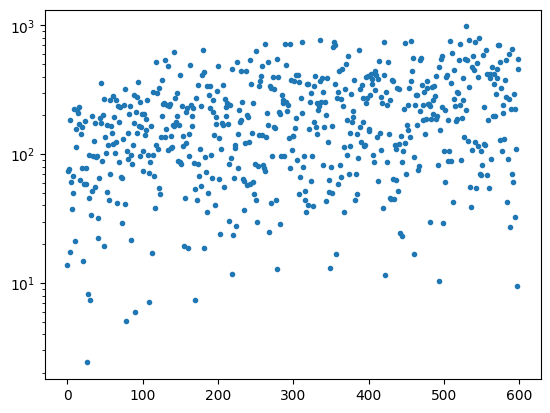

In [46]:
plt.plot(np.squeeze(pops[0].get_f()[np.argsort(pops[0].get_f()[:,0])[:600],:]) - [fit.fun for fit in local_fits],'.')
plt.yscale('log')

In [38]:
print(np.arange(15))
print(np.argsort([fit.fun for fit in local_fits])[:15])


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 4  9  0  1  2 16 13 14  5  3 45  7 12  6 15]


In [40]:
np.argsort([fit.fun for fit in local_fits])[:15]
local_fits[0].x

array([0.00115716, 0.0521422 , 0.06525401, ..., 0.16534265, 0.24093261,
       0.12788583])

In [42]:
myprob._setup_rr()
all_results_local = {s:[] for s in metadata['sample_labels']}
for k,c in enumerate(np.argsort([fit.fun for fit in local_fits])[:15]):
    res_dict = myprob._simulate(myprob._unscale(local_fits[c].x))
    [all_results_local[s].append(res_dict[s][:,myprob.cols[s]][myprob.rows[s],:]) for s in metadata['sample_labels']]

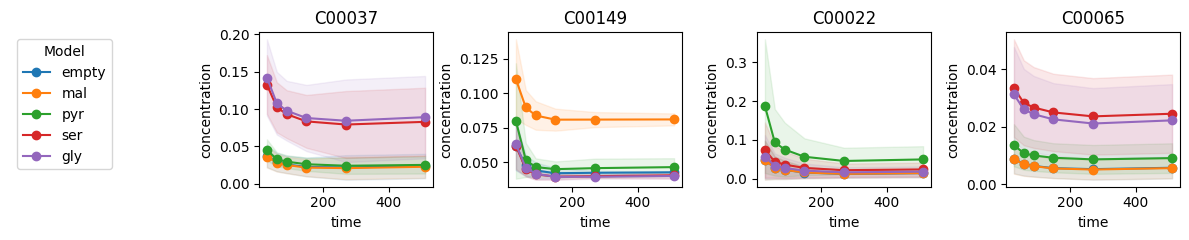

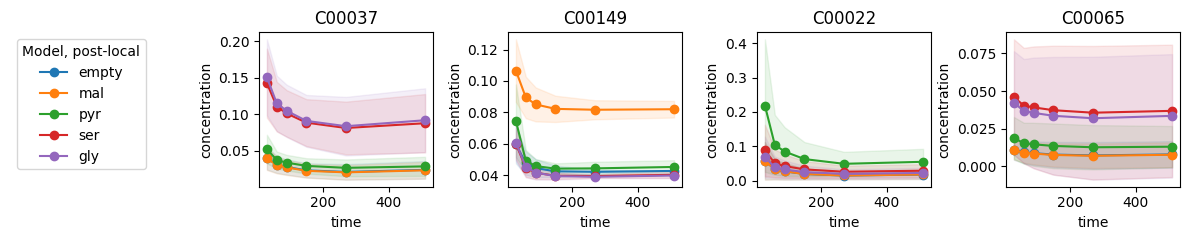

In [47]:
plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results[s],0)[:,i]
        std = np.std(all_results[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model')
plt.gca().axis('off')
plt.tight_layout()

plt.figure(figsize=(12,2.5))
for s in metadata['sample_labels']:
    for i,m in enumerate(metadata['measurement_labels']):
        plt.subplot(1,5,i+2)
        mean = np.mean(all_results_local[s],0)[:,i]
        std = np.std(all_results_local[s],0)[:,i]
        p = plt.plot(metadata['timepoints'][s]/60, mean,'-o')
        plt.fill_between(metadata['timepoints'][s]/60, mean - std, mean + std, alpha=0.1, color = p[-1].get_color())
        plt.title(m)
        plt.xlabel('time')
        plt.ylabel('concentration')

plt.subplot(1,5,1)
[plt.plot(metadata['timepoints'][s], measurements[s][:,i]/np.nan,'-o') for s in metadata['sample_labels']]
plt.legend(metadata['sample_labels'], loc='upper left', title='Model, post-local')
plt.gca().axis('off')
plt.tight_layout()

In [35]:
top = pops[0].get_x()[np.argsort(pops[0].get_f()[:,0])[:60],:]
mean = np.array(top.mean(axis=0))
std = np.array(top.std(axis=0))

std[(mean<0.9)*(mean>0.1)] = np.nan
plot_labels = np.array(parameter_labels)
plot_labels[(mean<0.9)*(mean>0.1)] = ''
inital = test_myprob._scale(p_initial)
inital[(mean<0.9)*(mean>0.1)] = np.nan
mean[(mean<0.9)*(mean>0.1)] = np.nan


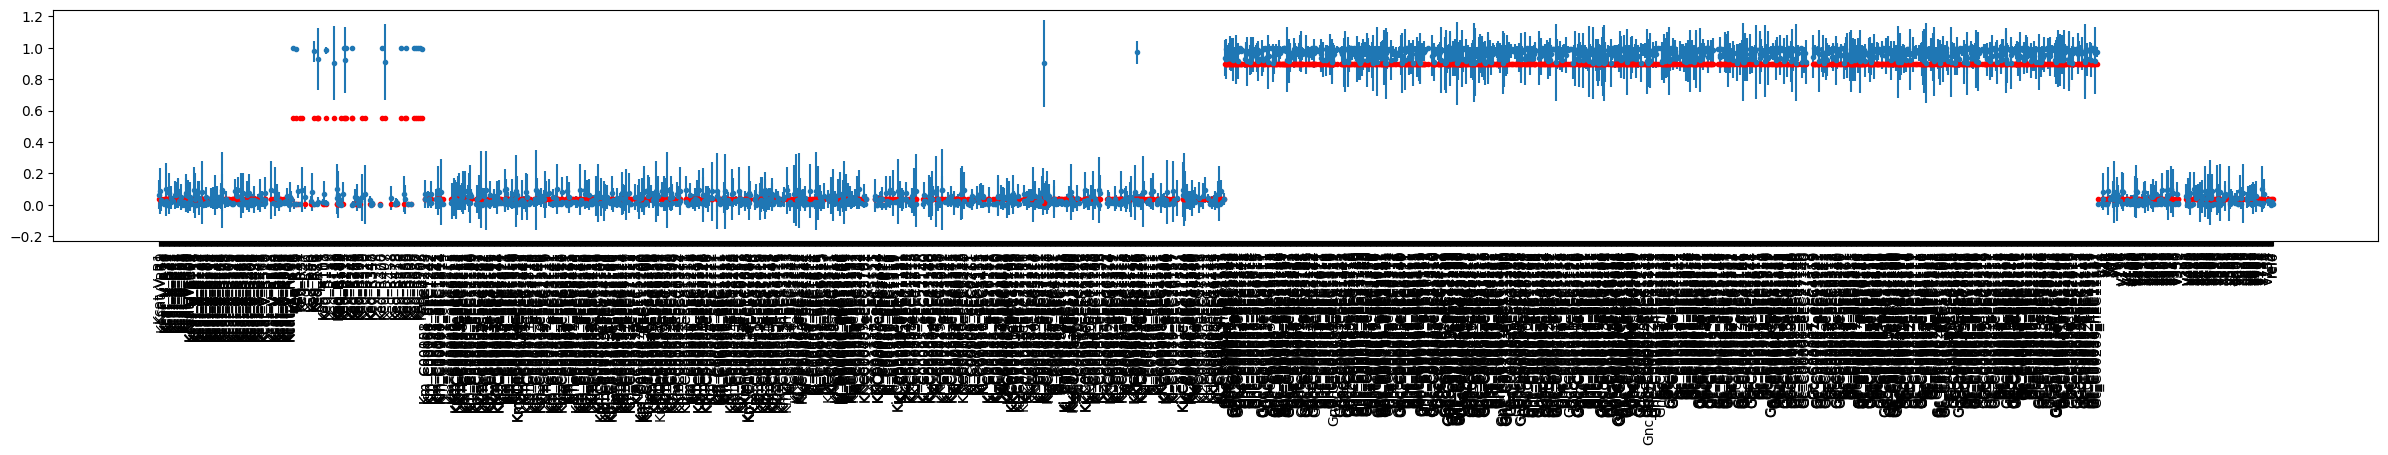

In [36]:
plt.figure(figsize=(30,3))
plt.errorbar(range(len(top[0,:])),mean,yerr=std, fmt='.')
plt.plot(range(len(top[0,:])),inital,'r.')
plt.xticks(range(len(plot_labels)),plot_labels, rotation = 90);

In [34]:
train_myprob.r[0].getValue('Kcat_F_R1')

5.156910298476282

In [35]:
sum(~np.isnan(mean))

1974

In [129]:
pops[0]

Problem name: Global Fitting of Multiple SBML Models
	C++ class name: pybind11::object

	Global dimension:			2086
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Population size: 600

List of individuals: 
#0:
	ID:			9407373198011705498
	Decision vector:	[0.500069, 0.564347, 0.782746, 0.765065, 0.351193, ... ]
	Fitness vector:		[0.187605]
#1:
	ID:			17493546193569798522
	Decision vector:	[0.701614, 0.49338, 0.347621, 0.307061, 0.678488, ... ]
	Fitness vector:		[0.198125]
#2:
	ID:			5946853286484627270
	Decision vector:	[0.711658, 0.281732, 0.343787, 0.416532, 0.749577, ... ]
	Fitness vector:		[0.189979]
#

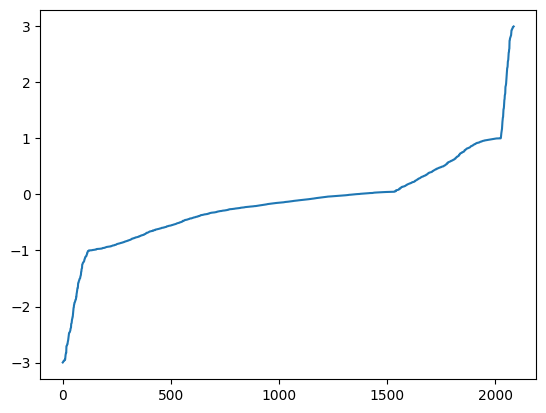

In [130]:
plt.plot(np.sort(train_myprob._unscale(pops[0].champion_x)-p_initial))

In [131]:
np.argsort(train_myprob._unscale(pops[0].champion_x)-p_initial)

array([1949, 2069, 1950, ..., 1956, 1922, 1929])

In [132]:
parameter_labels[1949]

'v265'

<Axes: xlabel='sample'>

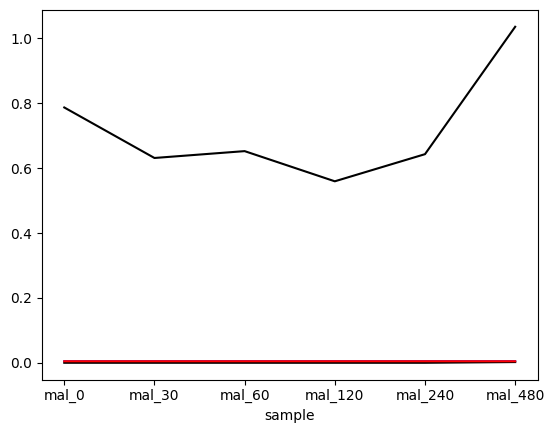

In [137]:
kegg = 'C00022'
sample = 5
test_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']][kegg].plot(color='b')
test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == 23]['sample']][kegg].plot(color='k')

test_results_df.set_index('sample').loc[test_index_map[test_index_map['index'] == sample]['sample']][kegg].plot(color='r')
test_data_df.set_index('sample').loc[test_index_map[test_index_map['index'] == sample]['sample']][kegg].plot(color='k')
